# Feature Extraction - Image Segmentation

In the previous activity, we did feature extraction from images using ImageJ. But what if we want to integrate 
feature extraction if we have repetitive imaging experiments? We can automate image feature extraction in 
three steps: **segmentation, morphological operations, and blob analysis**. Automating feature extraction helps 
us efficiently gather training data for machine learning. In this activity we begin with **Image Segmentation**.

In [122]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
from matplotlib.patches import Rectangle

plt.rcParams["figure.figsize"] = (4,4)
# plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Segmentation by thresholding
In image segmentation, a region of interest (ROI) is picked out from the rest of the image or background such 
that further processing can be done on it. Selection rules are based on features unique to the ROI. For grayscale images, segmentation can be done through **thresholding** if the ROI has a distinct grayscale range from the background. 

(-0.5, 1649.5, 536.5, -0.5)

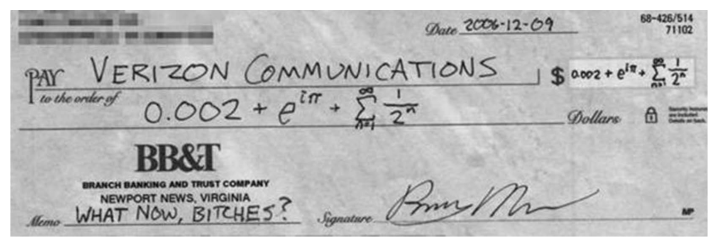

In [2]:
grayscale_check = Image.open("grayscale check.png")
grayscale_check = np.array(grayscale_check.convert("L"))

plt.figure(figsize = (9, 4))
plt.imshow(grayscale_check, cmap = "gray")
plt.axis("off")

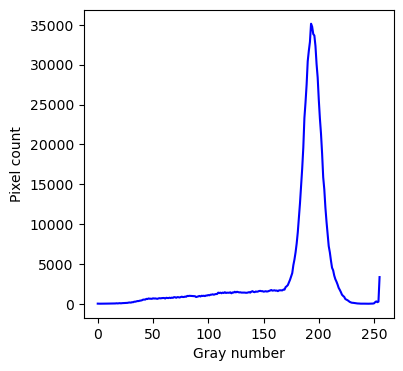

In [79]:
check_hist, check_edge = np.histogram(grayscale_check, 256)

plt.plot(check_hist, color = "blue")
plt.xlabel("Gray number")
plt.ylabel("Pixel count")
plt.savefig("grayscale check histogram.png")

(-0.5, 1649.5, 536.5, -0.5)

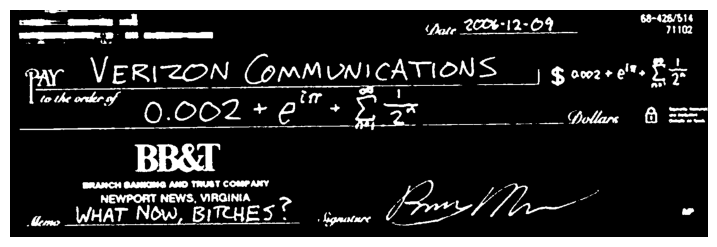

In [4]:
grayscale_check_new = grayscale_check < 125

plt.figure(figsize = (9, 4))
plt.imshow(grayscale_check_new, cmap = "gray")
plt.axis("off")

From the histogram shown above, the large peak corresponds to the background pixels. They occupy more space than the text. We can choose another threshold values that will clip values below the peak at around 200.

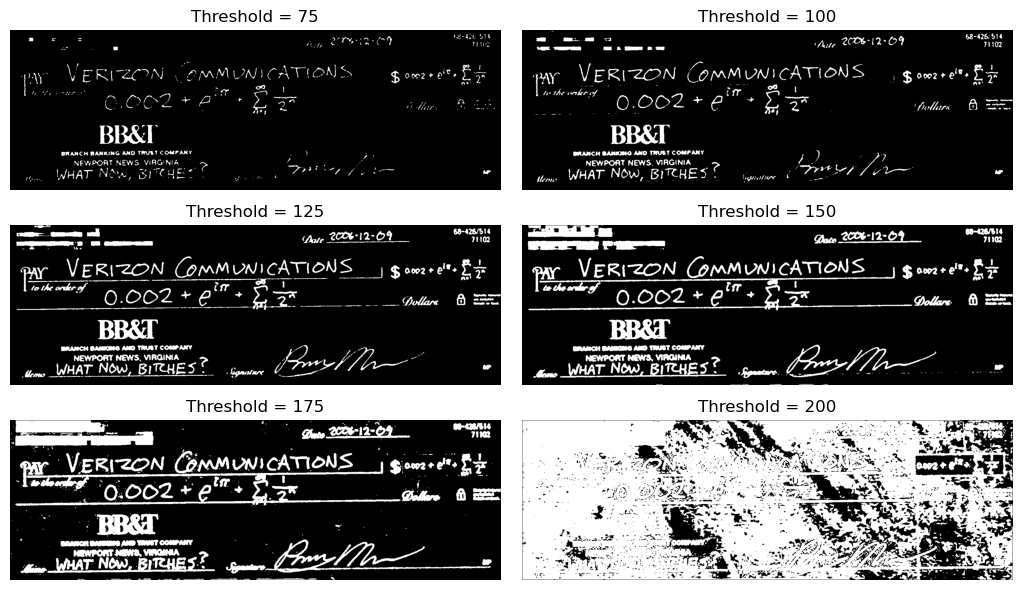

In [5]:
fig, ax = plt.subplots(3, 2, figsize = (11, 6), tight_layout = True)
thresholds = np.array([75, 100, 125, 150, 175, 200])
thresholds = thresholds.reshape(3, 2)

for i in range(3):
    for j in range(2):
        ax[i,j].imshow(grayscale_check < thresholds[i,j], cmap = "gray")
        ax[i,j].set_title("Threshold = {}".format(thresholds[i,j]))
        ax[i,j].axis("off")
        
plt.subplots_adjust(wspace = -0.15)
fig.savefig("different threshold values.png")

***
## Parametric segmentation
Segmenting regions of interest can easily be done in grayscale images by thresholding, but it is sometimes not possible to do so. If our task is to segment some colored object in an image, we cannot do it in grayscale since the object has the same grayscale value as the background upon conversion.

Color has been used to segment images of skin regions in face and hand recognition, land cover in remote 
sensing, and cells in microscopy. Inherently, 3D objects will have shading variations. To some extent shadows can be seen as differing brightness levels of the same color. For example, a red ball such as in the figure below will appear to have various shades of red from top to bottom and interreflections. For this reason, it is better to represent color space not by the RGB but by one that can separate brightness and chromaticity (pure color) information. One such color space is the **normalized chromaticity coordinates** or NCC.

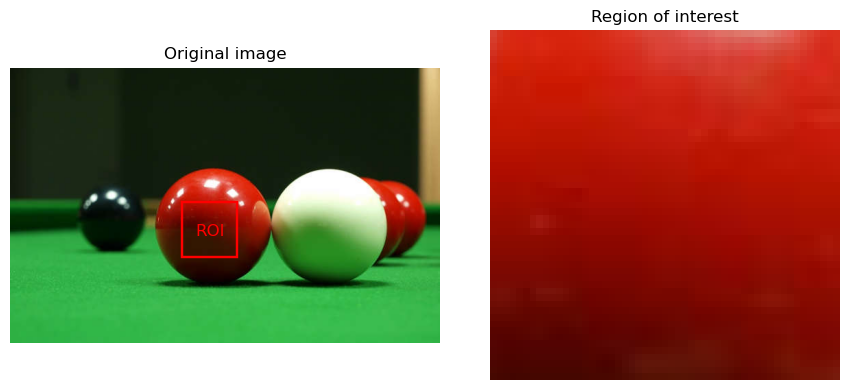

In [159]:
colored_balls = Image.open("colored balls.png")
colored_balls_RGB = np.array(colored_balls.convert("RGB"))
colored_balls_ROI = Image.open("colored balls ROI.png")
colored_balls_ROI_RGB = np.array(colored_balls_ROI.convert("RGB"))

fig, ax = plt.subplots(1, 2, figsize = (9, 4), tight_layout = True)
ax[0].imshow(colored_balls_RGB)
ax[0].set_title("Original image")

rect = Rectangle((250, 195), 80, 80, linewidth = 1.75, edgecolor = "red", facecolor = "none")
ax[0].add_patch(rect)
ax[0].annotate("ROI", (270, 245), color = "red", fontsize = 12)

ax[1].imshow(colored_balls_ROI_RGB)
ax[1].set_title("Region of interest")

for a in ax:
    a.axis("off")

Per pixel, we let $I = R+G+B$. Then the normalized chromaticity coordinates are $$ r = \frac{R}{R+G+B} = \frac{R}{I}, \quad g = \frac{G}{I}, \quad b = \frac{B}{I} $$ We note that $r+g+b = 1$ which implies $r$,$g$, and $b$ can only have values between 1 and 0 and b is dependent on $r$ 
and $g$ since $b = 1-r-g$. Therefore, it is enough to represent chromaticity by just two coordinates, $r$ and $g$. 
Thus, from RGB, the color space has been transformed to $rg$ I where chromatic information is in $r$ and $g$ while brightness information is in $I$. We have thus reduced color information from three dimensions to two! Thus, 
when segmenting 3D objects, it is better to first transform RGB into rgI. Any color therefore can be represented as a point in NCC space.

In [114]:
def NCC(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = R + G + B
    r, g, b = R/I, g/I, 1-r-g
    return r, g, b

Segmentation based on color can be performed by determining the **probability that a pixel belongs to a color 
distribution of interest**. This implies that the **color histogram** of the region of interest must first be extracted. To do so, one crops a subregion of the ROI and compute the histogram from it. The histogram when normalized by the number of pixels is already the probability distribution function (PDF) of the color. To tag a pixel as belonging to a region of interest or not is to find its probability of belonging to the color of the ROI.

Since our space is $r$ and $g$ we can have a joint probability $p(r)p(g)$ function to test the likelihood of pixel membership to the ROI. We can assume a **Gaussian distribution** independently along $r$ and $g$, that is, from the $r$-$g$ values of the cropped pixel we compute the mean $\mu$ and standard deviation $\sigma$ from the pixel samples.

The probability that a pixel with chromaticity $r$ belongs to the ROI is then $$ p(r) = \frac{1}{\sigma_r \sqrt{2\pi}} \exp \left[-\frac{\left(r-\mu_r\right)^2}{2\sigma_r^2} \right] $$ A similar equation is computed for $g$. The joint probability is taken as the product of the two.

In [12]:
def gaussian_PDF(orig_img, roi_img):
    mu = np.mean(roi_img)
    sigma = np.std(roi_img)
    gaussian = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(orig_img - mu)**2/(2*sigma**2))
    return gaussian

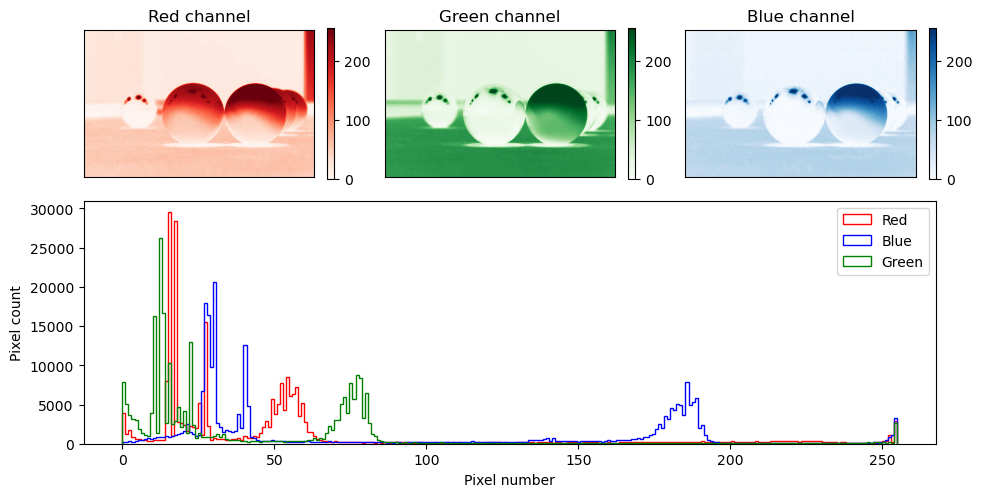

In [113]:
fig = plt.figure(figsize = (11, 6), tight_layout = True)
gridspec = fig.add_gridspec(2, 3, hspace = -0.1)

ax1 = fig.add_subplot(gridspec[0,0])
red_channel = ax1.imshow(colored_balls_RGB[:,:,0], cmap = "Reds")
plt.colorbar(red_channel, ax = ax1, fraction = 0.03)
ax1.set_title("Red channel")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gridspec[0,1])
green_channel = ax2.imshow(colored_balls_RGB[:,:,1], cmap = "Greens")
plt.colorbar(green_channel, ax = ax2, fraction = 0.03)
ax2.set_title("Green channel")
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gridspec[0,2])
blue_channel = ax3.imshow(colored_balls_RGB[:,:,2], cmap = "Blues")
plt.colorbar(blue_channel, ax = ax3, fraction = 0.03)
ax3.set_title("Blue channel")
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_subplot(gridspec[1,:])
ax4.hist(colored_balls_RGB[:,:,0].flatten(), 256, histtype = "step", ec = "red", label = "Red")
ax4.hist(colored_balls_RGB[:,:,1].flatten(), 256, histtype = "step", ec = "blue", label = "Blue")
ax4.hist(colored_balls_RGB[:,:,2].flatten(), 256, histtype = "step", ec = "green", label = "Green")
ax4.set_xlabel("Pixel number")
ax4.set_ylabel("Pixel count")
ax4.legend()

plt.savefig("colored balls rgb channels and histogram.png")